In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
addr = "../data/BTCUSDT-5m-5klines.csv"
df = pd.read_csv(addr)
df = df.set_index('id')
df = df.drop(columns=['high', 'low', 'close', 'open time', 'ignore', 'close time'])

In [81]:
df

,open,volume,quote asset volume,number of trades,taker buy base asset volume,taker buy quote asset volume
id,,,,,,
0,61299.81,222.81992,1.364898e+07,7167,115.97095,7.104265e+06
1,61243.61,108.69289,6.667627e+06,4355,63.90645,3.920247e+06
2,61390.00,167.37244,1.028743e+07,5126,88.99605,5.470514e+06
3,61520.03,183.82887,1.131521e+07,6585,80.98348,4.985408e+06
4,61644.16,142.40028,8.761666e+06,4978,57.37836,3.530186e+06
...,...,...,...,...,...,...
4995,59538.36,129.79815,7.730709e+06,5056,62.86066,3.745183e+06
4996,59651.60,66.62732,3.978887e+06,3089,38.54241,2.301684e+06
4997,59698.88,83.59202,4.993660e+06,3037,41.33915,2.469525e+06


In [82]:
def graph(feature):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 50
    fig_size[1] = 5
    plt.rcParams["figure.figsize"] = fig_size
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.title(feature)
    plt.plot(df[feature].iloc[-1000:])

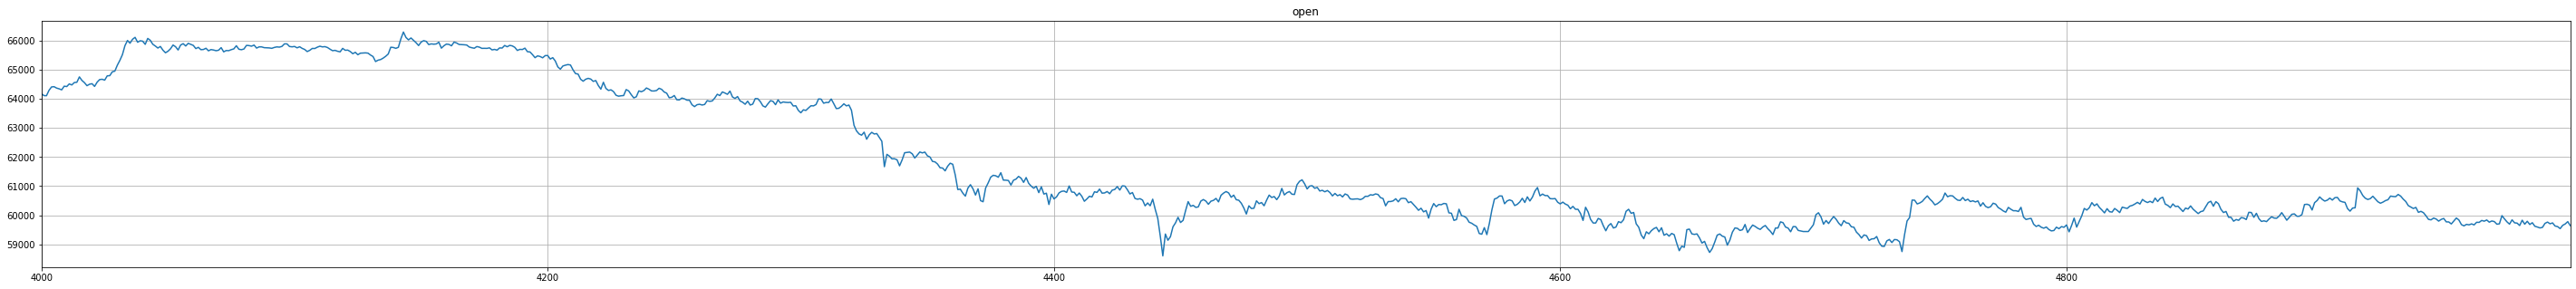

In [83]:
graph('open')

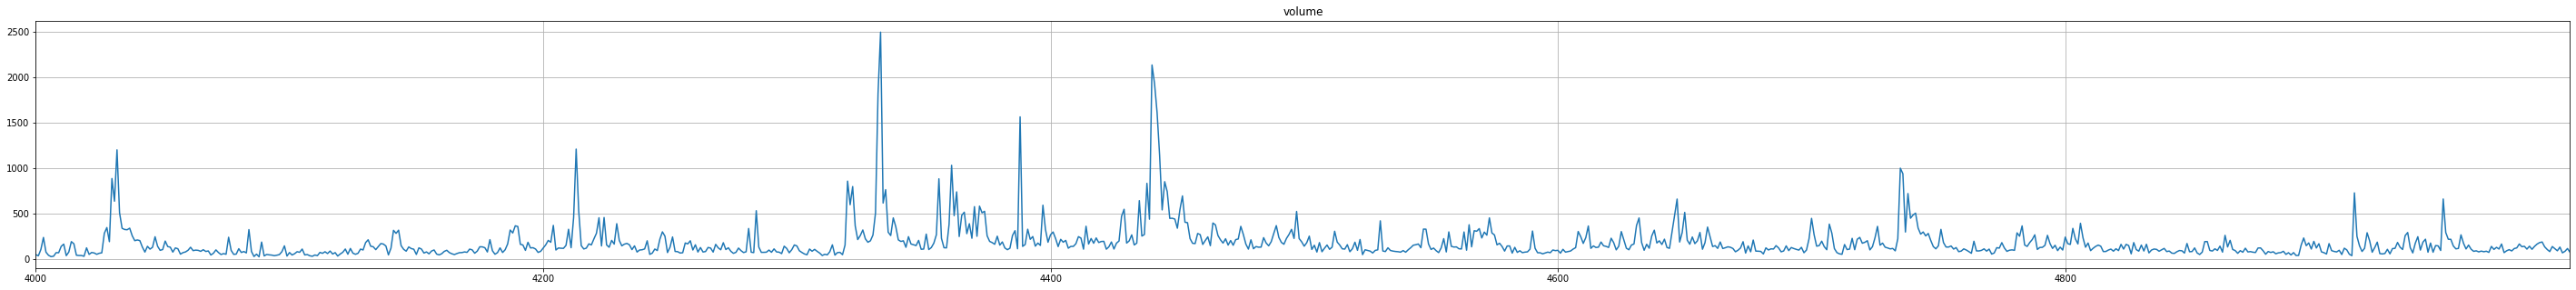

In [84]:
graph('volume')

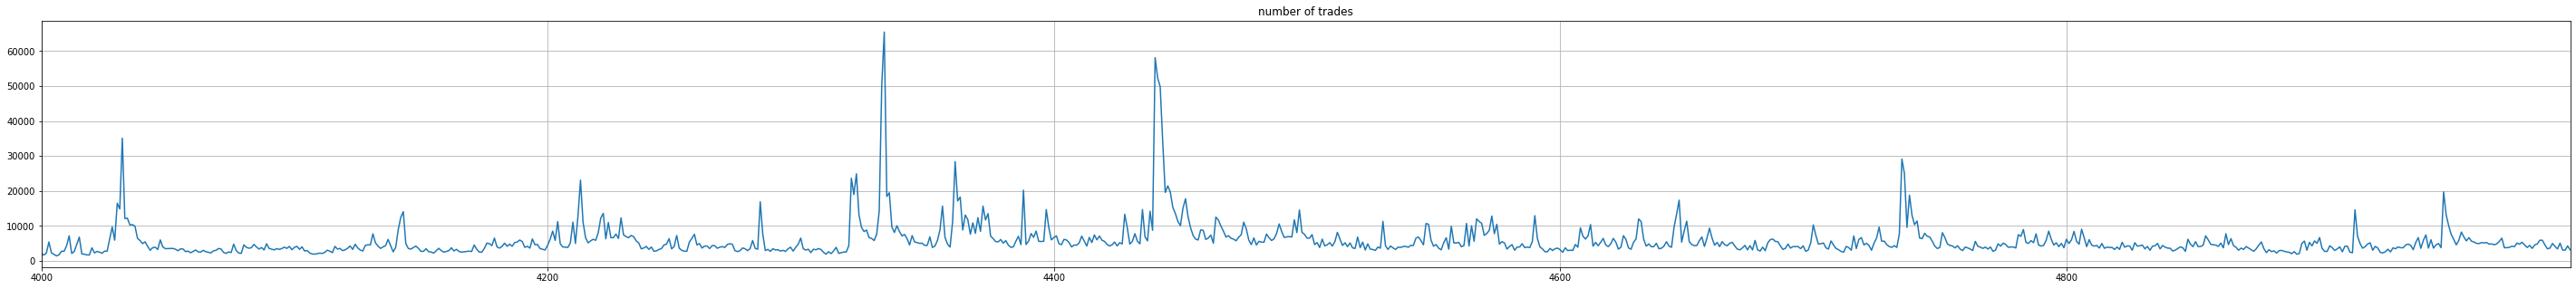

In [85]:
graph('number of trades')

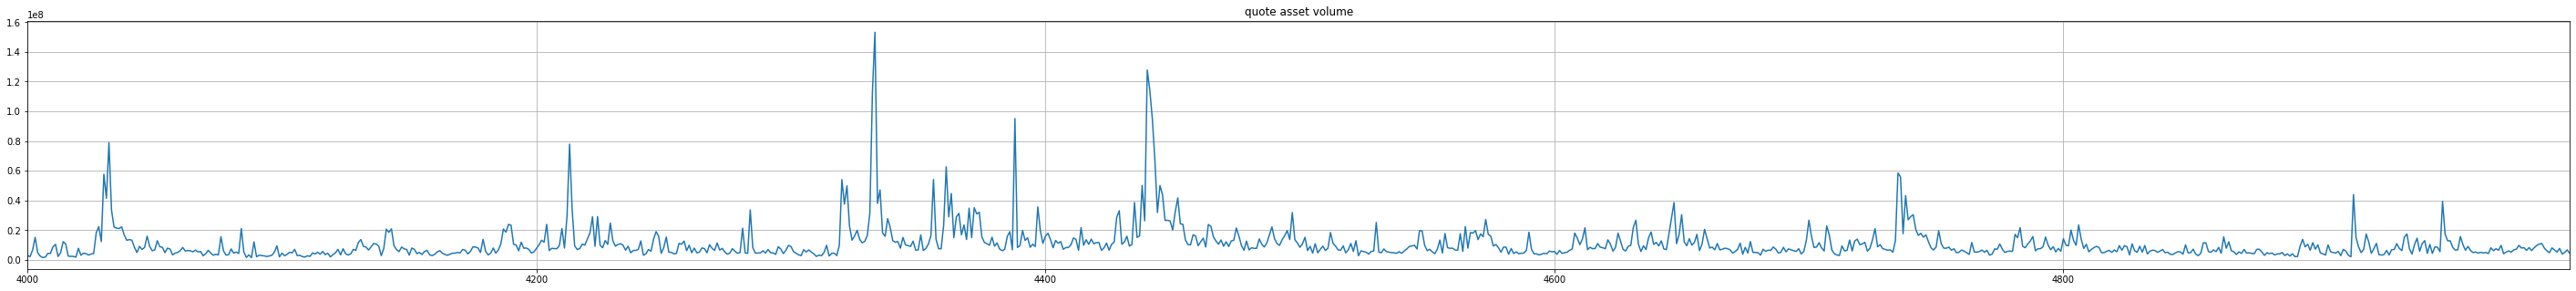

In [86]:
graph('quote asset volume')

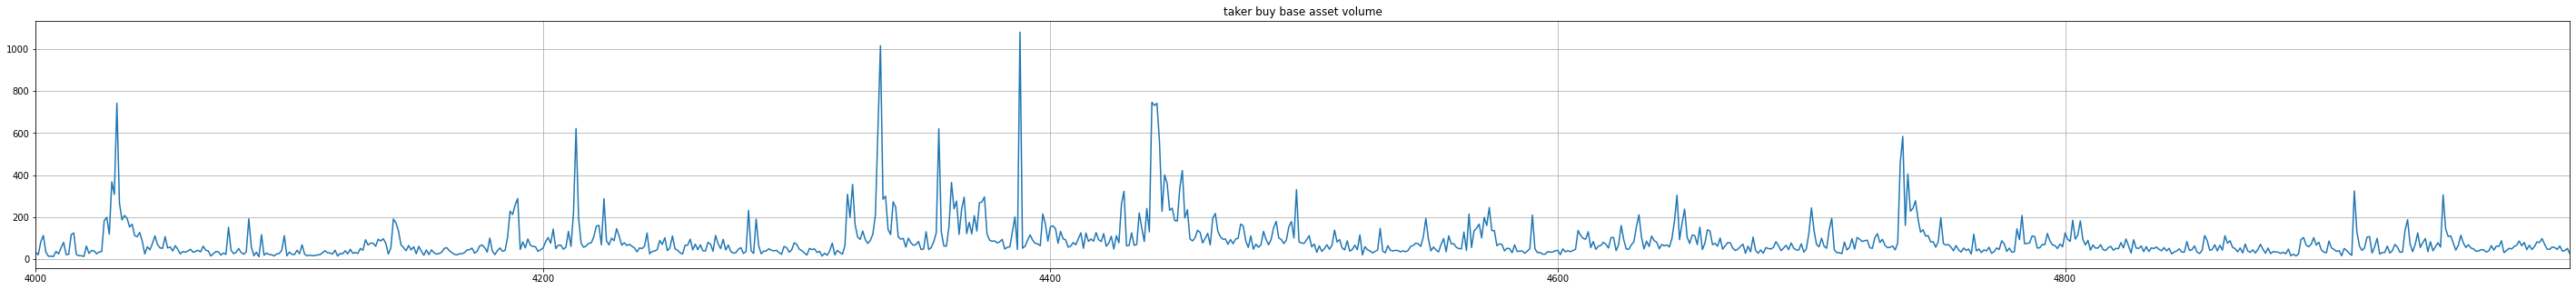

In [87]:
graph("taker buy base asset volume")

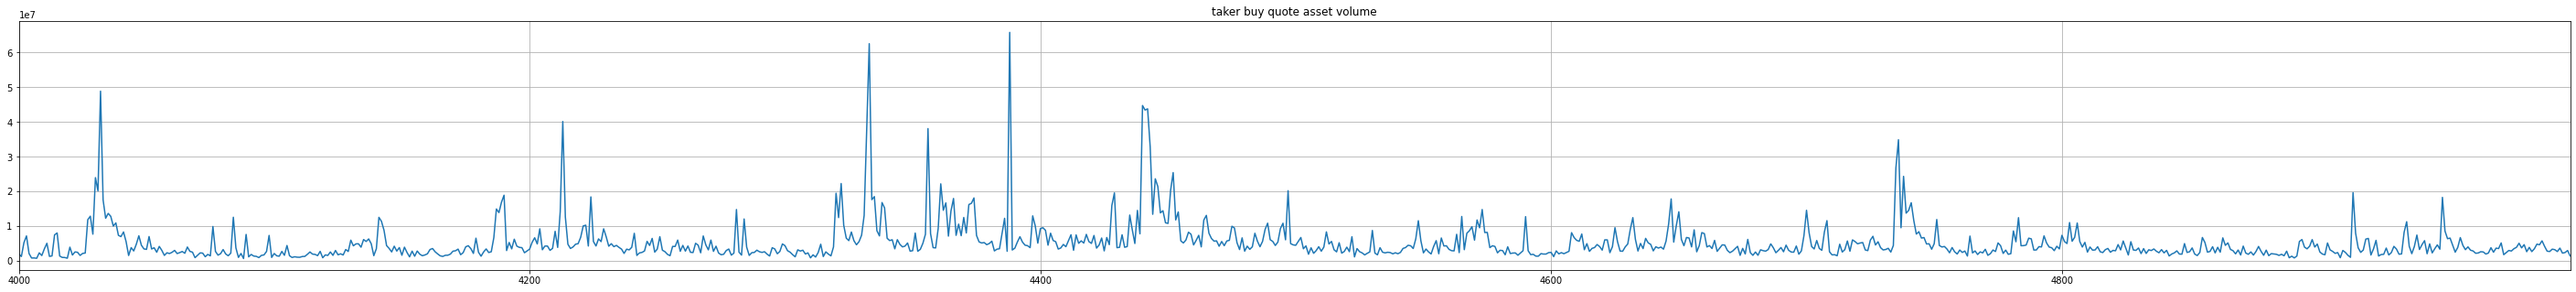

In [88]:
graph("taker buy quote asset volume")

In [89]:
all_data = df.values.astype(float)

test_data_size = 576 # 48 hrs
train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]
print(len(train_data))
print(len(test_data))

4424
576


In [90]:
# normalize features to [-1,1]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data.reshape(-1,6))

all_data_normalized = scaler.fit_transform(all_data.reshape(-1,6))
train_data_normalized = torch.FloatTensor(train_data_normalized)
train_data_normalized

tensor([[-0.6530, -0.8695, -0.8752, -0.8775, -0.8064, -0.8080],
        [-0.6655, -0.9434, -0.9458, -0.9373, -0.8990, -0.9000],
        [-0.6329, -0.9054, -0.9092, -0.9209, -0.8544, -0.8552],
        ...,
        [-0.7612, -0.8888, -0.8947, -0.9300, -0.7964, -0.8000],
        [-0.7778, -0.9448, -0.9477, -0.9394, -0.9031, -0.9050],
        [-0.7504, -0.9279, -0.9316, -0.9324, -0.8776, -0.8798]])

In [91]:
train_window = 12 # 1 hours' data

In [92]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1][0][0].view(1)
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [93]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
train_inout_seq[0]

(tensor([[-0.6530, -0.8695, -0.8752, -0.8775, -0.8064, -0.8080],
         [-0.6655, -0.9434, -0.9458, -0.9373, -0.8990, -0.9000],
         [-0.6329, -0.9054, -0.9092, -0.9209, -0.8544, -0.8552],
         [-0.6040, -0.8947, -0.8988, -0.8899, -0.8686, -0.8692],
         [-0.5764, -0.9216, -0.9246, -0.9241, -0.9107, -0.9113],
         [-0.6154, -0.9469, -0.9489, -0.9562, -0.9279, -0.9285],
         [-0.6084, -0.9501, -0.9521, -0.9472, -0.9439, -0.9445],
         [-0.6210, -0.9603, -0.9619, -0.9553, -0.9369, -0.9375],
         [-0.6063, -0.9588, -0.9605, -0.9533, -0.9469, -0.9475],
         [-0.6380, -0.9817, -0.9824, -0.9644, -0.9658, -0.9664],
         [-0.6276, -0.9639, -0.9653, -0.9632, -0.9298, -0.9305],
         [-0.6096, -0.9474, -0.9495, -0.9643, -0.9203, -0.9210]]),
 tensor([-0.5950]))

In [94]:
class LSTM(nn.Module):
    def __init__(self, input_size=6, hidden_layer_size=128, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=2)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(2,1,self.hidden_layer_size),
                            torch.zeros(2,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        
        '''if(use_gpu):
            lstm_out = lstm_out.cuda()'''
        
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [95]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)


'''if(use_gpu):
    model = model.cuda()
    loss_function = loss_function.cuda()'''
print(model)

LSTM(
  (lstm): LSTM(6, 128, num_layers=2)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


In [96]:
# training

epochs = 100
single_loss_list = []

for i in range(epochs):
    total_MSE = 0
    for seq, labels in train_inout_seq:
                
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size),
                        torch.zeros(2, 1, model.hidden_layer_size))
        

        y_pred = model(seq)
        
        single_loss = loss_function(y_pred, labels)
        
        total_MSE = single_loss.item() + total_MSE #calculate MSE on the entire training set
        
        if i == (epochs-1) :
            single_loss_list.append(single_loss.item())
                
        
        single_loss.backward()
        optimizer.step()
        
    scheduler.step()
        
    MSE = total_MSE / len(train_inout_seq)
    print(f'epoch: {i:3} loss: {MSE:10.8f}')
    
    #if i%25 == 1:
        #print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   0 loss: 0.00459004
epoch:   1 loss: 0.00550191
epoch:   2 loss: 0.00617484
epoch:   3 loss: 0.00610229
epoch:   4 loss: 0.00671200
epoch:   5 loss: 0.00799653
epoch:   6 loss: 0.00948793
epoch:   7 loss: 0.00793896
epoch:   8 loss: 0.00682136
epoch:   9 loss: 0.00703750
epoch:  10 loss: 0.00971964
epoch:  11 loss: 0.00839499
epoch:  12 loss: 0.00742551
epoch:  13 loss: 0.00722858
epoch:  14 loss: 0.00624209
epoch:  15 loss: 0.00563079
epoch:  16 loss: 0.00413048
epoch:  17 loss: 0.00284473
epoch:  18 loss: 0.00221977
epoch:  19 loss: 0.00183870
epoch:  20 loss: 0.00163651
epoch:  21 loss: 0.00130410
epoch:  22 loss: 0.00113239
epoch:  23 loss: 0.00105448
epoch:  24 loss: 0.00103232
epoch:  25 loss: 0.00099253
epoch:  26 loss: 0.00097157
epoch:  27 loss: 0.00093055
epoch:  28 loss: 0.00088511
epoch:  29 loss: 0.00086831
epoch:  30 loss: 0.00089671
epoch:  31 loss: 0.00086424
epoch:  32 loss: 0.00072164
epoch:  33 loss: 0.00069143
epoch:  34 loss: 0.00066390
epoch:  35 loss: 0.0

In [135]:
import copy

def predict(input_seq, window_size):
    seq = torch.FloatTensor(input_seq[-window_size:])

    with torch.no_grad():
        model.hidden_cell = (torch.zeros(2, 1, model.hidden_layer_size),
                             torch.zeros(2, 1, model.hidden_layer_size))

        temp = model(seq)

        #print(input_seq)
        s = "Real:" + str(input_seq[train_window-1][0]) + "    " + "Predict:" + str(temp)
        print(s)
        return temp

In [230]:
test_data_normalized = scaler.fit_transform(test_data.reshape(-1,6)).tolist()

test_inputs = train_data_normalized[-train_window:].tolist()
model.eval()

test_inputs = test_inputs + test_data_normalized #cat

result = []
for i in range(len(test_inputs) - train_window):
    temp = test_inputs[i : i + train_window]
    prediction = predict(temp, train_window)
    result.append(prediction.item())

Real:-0.7503735423088074    Predict:tensor([-0.7461])
Real:0.745718896511633    Predict:tensor([0.4319])
Real:0.8218112566826505    Predict:tensor([0.9558])
Real:0.7306901008803166    Predict:tensor([0.8271])
Real:0.841689037774664    Predict:tensor([0.8369])
Real:0.8352874591775077    Predict:tensor([0.8548])
Real:0.7399215290365504    Predict:tensor([0.7454])
Real:0.6283107327780755    Predict:tensor([0.5699])
Real:0.6651217217722518    Predict:tensor([0.5981])
Real:0.5097553327367734    Predict:tensor([0.4706])
Real:0.48941100887960687    Predict:tensor([0.4267])
Real:0.5041032818606652    Predict:tensor([0.4480])
Real:0.46630566964183373    Predict:tensor([0.3451])
Real:0.3159106379398722    Predict:tensor([0.2810])
Real:0.3912917116000898    Predict:tensor([0.3049])
Real:0.31788388438916826    Predict:tensor([0.1534])
Real:0.4906423758499088    Predict:tensor([0.3585])
Real:0.22294625580310168    Predict:tensor([-0.0904])
Real:-0.012413096849691385    Predict:tensor([0.1040])
Real

Real:-0.20716793245073006    Predict:tensor([-0.1982])
Real:-0.07298717389807763    Predict:tensor([-0.0915])
Real:-0.13182510000076775    Predict:tensor([-0.1333])
Real:-0.1441617144299414    Predict:tensor([-0.1710])
Real:-0.23453334251122726    Predict:tensor([-0.2312])
Real:-0.24651048956397403    Predict:tensor([-0.2663])
Real:-0.3744273378763907    Predict:tensor([-0.3712])
Real:-0.44020986776189375    Predict:tensor([-0.4444])
Real:-0.5311168727867894    Predict:tensor([-0.5472])
Real:-0.44908947678376165    Predict:tensor([-0.4612])
Real:-0.4694873383352842    Predict:tensor([-0.4790])
Real:-0.5938630505778306    Predict:tensor([-0.6211])
Real:-0.5541763225722605    Predict:tensor([-0.5529])
Real:-0.5488760908305252    Predict:tensor([-0.5689])
Real:-0.4904358733145173    Predict:tensor([-0.5311])
Real:-0.6557296805329287    Predict:tensor([-0.7153])
Real:-0.7449999617587935    Predict:tensor([-0.7380])
Real:-0.7514244850821115    Predict:tensor([-0.7200])
Real:-0.6068038761290

Real:-0.08786300468837283    Predict:tensor([-0.0847])
Real:-0.04396209531239492    Predict:tensor([-0.0557])
Real:-0.0644058463162267    Predict:tensor([-0.0711])
Real:0.006348040902800278    Predict:tensor([-0.0144])
Real:-0.005636754392007504    Predict:tensor([-0.0323])
Real:-0.04406917070112115    Predict:tensor([-0.0553])
Real:0.14540837788434402    Predict:tensor([0.1025])
Real:0.1404523170349279    Predict:tensor([0.1142])
Real:0.014654031770795939    Predict:tensor([-0.0062])
Real:0.11925903831004092    Predict:tensor([0.0771])
Real:-0.022684685924943437    Predict:tensor([-0.0379])
Real:-0.09446343757887377    Predict:tensor([-0.1038])
Real:-0.07832564685007526    Predict:tensor([-0.0826])
Real:-0.09883058379031695    Predict:tensor([-0.1038])
Real:-0.030386465670872553    Predict:tensor([-0.0433])
Real:0.027571912595888648    Predict:tensor([-0.0029])
Real:-0.005935035832017377    Predict:tensor([-0.0312])
Real:-0.010929337891688817    Predict:tensor([-0.0315])
Real:0.046287

In [231]:
temp = [[result[i],0,0,0,0,0] for i in range(len(result))] # 0's are dummies

In [232]:
result = scaler.inverse_transform(np.array(temp).reshape(-1, 6))

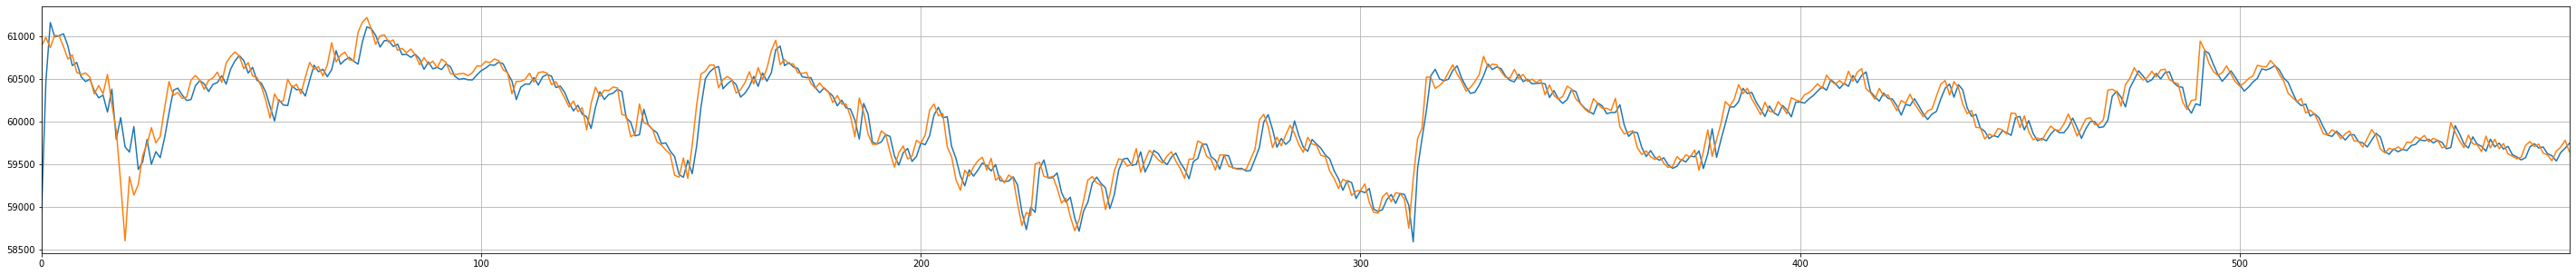

In [236]:
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(result[:,0])
plt.plot(np.array(test_data)[:,0])
plt.show()

In [238]:
# save as torch script
compiled_model = torch.jit.script(model)
torch.jit.save(compiled_model, 'model.pt')